# Word embedding
@author: huni

In [1]:
import os, re, datetime, pickle
from sys import platform
from tqdm import tqdm

from matplotlib.pyplot import cm
import matplotlib.pyplot as plt
import plotly

BASE_DIR = os.getcwd() ; print('Current WD: ', BASE_DIR)
if 'win32' in platform: # for window
    from eunjeon import Mecab
    plt.rc("font",family="Malgun Gothic")

elif 'darwin' in platform: # for mac
    from konlpy.tag import Mecab
    plt.rc('font', family='AppleGothic') 
    font_path= '/System/Library/Fonts/Supplemental/AppleGothic.ttf'


FILE_NAME = '220919_2021 STELA 발제내용.pkl'
pkl_obj = open(os.path.join(BASE_DIR, 'RESULT', FILE_NAME), 'rb')
res = pickle.load(pkl_obj)
print('>>> Length crawled: ', len(res))

Current WD:  /Users/huni/Proj/data_preprocessing/[crawler]notion
>>> Length crawled:  44


In [2]:
from cleaning import default

ClEANED = default(crawling_result= res)
print(type(ClEANED))
ClEANED.keys()

>> cleaning initate with :  44


>> cleaning each page: 44it [00:00, 2407.00it/s]

>> before:  Anonymous
>> before:  
>> before:  UNGGI LEE
>> before:  ­송유경
>> before:  Juno Hwang
>> before:  
>> before:  성지훈 ­
>> before:  이재용 ­
>> before:  성지훈 ­
>> before:  
>> before:  Juhong Eom
>> before:  UNGGI LEE
>> before:  Juno Hwang
>> before:  ­송유경
>> before:  이재용 ­
>> before:  성지훈 ­
>> before:  
>> before:  원지영(교육대학원 교육학과)
>> before:  Hyun-G, Kwon
>> before:  UNGGI LEE
>> before:  전영훈
>> before:  Y
Yoonhee Ham
>> before:  박
박용현 / 학생 / 물리교육과 ­
전영훈
>> before:  이재용 ­
>> before:  성지훈 ­
>> before:  박
박용현 / 학생 / 물리교육과 ­
>> before:  Juno Hwang
>> before:  전영훈
>> before:  UNGGI LEE
>> before:  UNGGI LEE
>> before:  임은선 ­
>> before:  Hyun-G, Kwon
>> before:  박새록(사범대학 교육공학과) ­
>> before:  이
이홍규
>> before:  Y
Yoonhee Ham
>> cleaning finished with :  17
<class 'dict'>


dict_keys(['Anonymous', '', 'UNGGILEE', '송유경', 'JunoHwang', '성지훈', '이재용', 'JuhongEom', '원지영(교육대학원교육학과)', 'Hyun-G,Kwon', '전영훈', 'YYoonheeHam', '박박용현/학생/물리교육과전영훈', '박박용현/학생/물리교육과', '임은선', '박새록(사범대학교육공학과)', '이이홍규'])

In [3]:
del ClEANED['Anonymous']
del ClEANED['']

In [4]:
tagger = Mecab()
print('문제가 될만한 단어 사용자사전 추가 전에 테스트')
print(tagger.nouns('학습분석'))
print(tagger.nouns('문항반응이론'))
print(tagger.nouns('요인분석'))
print(tagger.nouns('데이터'))
print(tagger.morphs('learning analytics')) ## morphs를 써야 다 분리됨
print(tagger.nouns('학습설계'))
print(tagger.nouns('학습디자인'))

문제가 될만한 단어 사용자사전 추가 전에 테스트
['학습', '분석']
['문항반응이론']
['요인', '분석']
['데이터']
['learning', 'analytics']
['학습', '설계']
['학습', '디자인']


In [5]:
from soynlp.hangle import decompose
from soynlp.hangle import compose

class Cleaning:
    def __init(self):
        pass

    @staticmethod
    def tokenize(input_text, morphs_opt=None):

        if morphs_opt == None:
            return tagger.morphs(input_text)
        elif morphs_opt == 'Noun':
            return tagger.nouns(input_text)
        else:
            print('error')
    
    @staticmethod
    def cleaning_text(input_text):
        output_text = input_text
        output_text = re.sub('[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ~`\.\,!@#$%^&*\(\)\[\]{}\-\_\'\"><\/\?=+\n:;…]', '', output_text) 

        return output_text


    @staticmethod
    def decompozer_text2(raw_sentence):
        decom_list = []
        words_list = Cleaning.tokenize(raw_sentence)   # noun 옵션을 쓰면 숫자나 영어까지 모두 날아가버리므로 전체 형태소를 다 씀
        
        for word in words_list:
            token_cjj = []
            for one_jamo in list(word):
                if re.match('[ㄱ-ㅎㅏ-ㅣ가-힣]', one_jamo) == None: # 한글이 없으면
                    token_cjj+=one_jamo  # 그대로 더함
                else:
                    decom_chr1 = decompose(one_jamo)  # 감 -> ['ㄱ', 'ㅏ', 'ㅁ'] / 고 -> ['ㄱ', 'ㅗ',' '] 으로 분리
                    token_cjj+=([x.replace(' ','_') for x in decom_chr1])  #  decompose에서 생성되는 빈 종성(' ')의 위치를 _로 대체
            decom_list.append(''.join(token_cjj))                          
        return decom_list

    @staticmethod
    def decode2(chrs):
        
        def process(t):
            assert len(t) % 3 == 0
            t_ = t.replace('_', ' ')
            chars = [tuple(t_[3*i:3*(i+1)]) for i in range(len(t_)//3)]
            recovered = [compose(*char) for char in chars]
            recovered = ''.join(recovered)
            return recovered

        chr_idx = 0
        decoded_chr_list = []

        while(chr_idx < len(chrs)):
            if re.match('[^ㄱ-ㅎㅏ-ㅣ가-힣_]', chrs[chr_idx]): # n번째 캐릭터가 한글 + '°'가 아니면
                decoded_chr_list.append(chrs[chr_idx]) # 추가 작업 없이 그대로 캐릭터 추가
                chr_idx += 1  # 다음 캐릭터로 진행
            else:
                temp_comp_chr = chrs[chr_idx]+chrs[chr_idx+1]+chrs[chr_idx+2] # 임시 완성형 글자 조합(초+중+종성)
                if re.match('[ㄱ-ㅎㅏ-ㅣ][ㄱ-ㅎㅏ-ㅣ][ㄱ-ㅎㅏ-ㅣ_]',temp_comp_chr): # 입력이 완성형 단어라면
                    decoded_chr_list.append(process(temp_comp_chr)) # 조합된 한 글자를 반환값에 추가
                    chr_idx += 3 # 인덱스 3 증가 = 다음 글자로 이동
                elif re.match('[ㄱ-ㅎ][_][_]',temp_comp_chr): # 입력이 [ㅋ,_,_] 같은 자음이라면
                    decoded_chr_list.append(temp_comp_chr[0]) # 자음 한 자를 반환값에 추가
                    chr_idx += 3 # 인덱스 3 증가 = 다음 글자로 이동
                elif re.match('[°][ㅏ-ㅣ][_]',temp_comp_chr): # 입력이 [_,ㅜ__] 같은 모음이라면
                    decoded_chr_list.append(temp_comp_chr[1]) # 모음 한 글자를 반환값에 추가
                    chr_idx += 3 # 인덱스 3 증가 = 다음 글자로 이동

        return ''.join(decoded_chr_list)

cleaner = Cleaning()
print(cleaner.cleaning_text(ClEANED['성지훈']['content']))

1. A Brief Introduction of Epistemic Network Analysis 1.1 이전 ENA 발표자료 1.2 ENA의 배경 1.2.1 전문성(Expertise) 1.2.2 전문성의 세대변화 1.3 Advantages of ENA 1.4 Various way to implement ENA 2. Modeling Spatial Behaviors in Clinical Team Simulations using Epistemic Network Analysis: Methodology and Teacher Evaluation 3. 논의 1. A Brief Introduction of Epistemic Network Analysis 1.1 이전 ENA 발표자료 example of Theory-based approach: ENA   이전 발표에서 틀린 부분: 네트워크 시각화 코드  노드를 고정하는 방법이 단순하지 않음 cf. ENA의 한글번역 1.2 ENA의 배경 본 절을 구성하는데 참고한 자료 1.2.1 전문성(Expertise) Def. Expertise 특정 영역에서 개인이 보유한 뛰어난 문제해결능력 Insight for Instructional Design Educational Goal:  from novice to expert!  What is the efficient way to become an expert?   How can we measure/represent/reveal expertise? 1.2.2 전문성의 세대변화 ref. Holyoak (1991)  1st generation of expertise (~1970s) Newell & Simon(1972) : 문제해결과정은 순차적으로 이뤄지는 탐색 행위다.  그 탐색적 행위가 경험에 따라서 일정한 체계를 가진다. (expertise) 전문가의 경험적 탐색행위를 모방하는 인공지능의 등장 :  "Logic Theorist" "General Problem Solver"  전문가는 domain

In [6]:
original_sent = "#고구마 참치 123 BibimBob은 맛있습니다!!ㅋ~ㅋㅋㅋㅋ"
print(original_sent)

print('------------------------------------------')

decom_sent = cleaner.decompozer_text2(original_sent)  # 단어 -> 초중종성 자소분리
print(decom_sent)

print('------------------------------------------')

decoded_sent = cleaner.decode2(list(' '.join(decom_sent)))  # 자소 -> 단어
print(decoded_sent)

#고구마 참치 123 BibimBob은 맛있습니다!!ㅋ~ㅋㅋㅋㅋ
------------------------------------------
['#', 'ㄱㅗ_', 'ㄱㅜ_ㅁㅏ_', 'ㅊㅏㅁㅊㅣ_', '123', 'BibimBob', 'ㅇㅡㄴ', 'ㅁㅏㅅㅇㅣㅆ', 'ㅅㅡㅂㄴㅣ_ㄷㅏ_', '!', '!', 'ㅋ__', '~', 'ㅋ__ㅋ__', 'ㅋ__ㅋ__']
------------------------------------------
# 고 구마 참치 123 BibimBob 은 맛있 습니다 ! ! ㅋ ~ ㅋㅋ ㅋㅋ


# Build Model

In [7]:
from gensim.models import FastText  # 라이브러리 명칭 조심
class MyInputIter(object):
    def __init__(self, input_list):
        self.input_list = input_list
    
    def __iter__(self):
        for input1 in self.input_list:
             yield input1
   
    
    
def make_fastText_model(input_CORPUS, fT_params):
                    # 모델 저장 위치, 모델 명, 학습 데이터
    
    print('> preprocessing...')
    
    sentences = MyInputIter(input_CORPUS)

    model = FastText(  
                        sg  = 1,    # : ({1, 0}, optional) – Training algorithm: skip-gram if sg=1, otherwise CBOW.
                        vector_size = 100,    # : Size of embeddings to be learnt (Default 100)
                        window = 3,    # : Context window size (Default 5)
                        min_count = fT_params['min_count'],    # : Ignore words with number of occurrences below this (Default 5)
                        min_n = 3,    #: min length of char ngrams (Default 3)
                        max_n = 9,    #: max length of char ngrams (Default 6)
                        workers = os.cpu_count()-1
                        # iter = fT_params['iter'],    # : Number of epochs (Default 5)
                        # alpha = ,    # : Initial learning rate (Default 0.025)
                        # loss = ,    # : Training objective. Allowed values: ns, hs, softmax (Default ns)
#                       # epochs = 10,    # : Number of epochs (Default 5)
                     )

    print('> build vocab...')
    
    # vocab 빌드
    model.build_vocab(corpus_iterable= sentences)
    
    print('> train model...')
    
    # 모델 훈련 시작
    model.train(corpus_iterable=sentences, total_examples=model.corpus_count, epochs = model.epochs)  # train
        
    # ------------------------------
    print('** model build complete')
    print('   ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~   ')
    
    # 모델을 반환하여 밖에서 분석 수행
    return model

/Users/huni/.pyenv/versions/3.8.2/envs/{huni}/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [8]:
CORPUS = [cleaner.cleaning_text(x['content']) for x in ClEANED.values()]
CORPUS_tokenized = [cleaner.decompozer_text2(x) for x in CORPUS]
print(f'input tokens: {CORPUS_tokenized[3][:30]}')

input tokens: ['1', '.', 'A', 'Brief', 'Introduction', 'of', 'Epistemic', 'Network', 'Analysis', '1', '.', '1', 'ㅇㅣ_ㅈㅓㄴ', 'ENA', 'ㅂㅏㄹㅍㅛ_', 'ㅈㅏ_ㄹㅛ_', '1', '.', '2', 'ENA', 'ㅇㅢ_', 'ㅂㅐ_ㄱㅕㅇ', '1', '.', '2', '.', '1', 'ㅈㅓㄴㅁㅜㄴ', 'ㅅㅓㅇ', '(']


In [9]:
# 모델
fT_params = {  
               'min_count' : 3,    # : Ignore words with number of occurrences below this (Default 5)
               # 'iter' : 50    # : Number of epochs (Default 5)
            }

# 모델 빌드
print('\n\n>>> Build model start\n')
fT_model = make_fastText_model(CORPUS_tokenized, fT_params)



>>> Build model start

> preprocessing...
> build vocab...
> train model...
** model build complete
   ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~  ~   


In [10]:
# # save model
# fT_model.save(os.path.join(BASE_DIR, 'RESULT', 'fT.model'))


# load model
# from gensim.models import FastText
# fT_model = FastText.load(os.path.join(BASE_DIR, 'RESULT', 'fT.model'))

In [11]:
def get_similar_word(ft_model, input_word, topN):
    jamo_token = cleaner.decompozer_text2(input_word)   # 입력 단어 자모화
    word_n_corr = ft_model.wv.most_similar(jamo_token, topn = topN)  # 모델에서 상위 N개의 유사한 토큰을 찾기
    word_n_corr = [(cleaner.decode2(word), corr) for (word, corr) in word_n_corr]   # 찾은 토큰을 디코드하여 유사도와 함께 반환
    
    return word_n_corr


# 두 모델 간 유사 단어 비교 함수
def compare_similar_words(EDU_model, YOUTUBE_model, compare_word, topN):

    decomp_word = cleaner.decompozer_text2(compare_word)[0]  

    # vocab 리스트 생성
    EDU_vocab_list = EDU_model.wv.vocab
    YOUTUBE_vocab_list = YOUTUBE_model.wv.vocab
    
    # 특정 모델의 vocab에 입력 단어가 없으면 비교 중지
    if decomp_word not in EDU_vocab_list:
        print(f'{compare_word} not in EDU model vocab')
        return None
    elif decomp_word not in YOUTUBE_vocab_list:
        print(f'{compare_word} not in YOUTUBE model vocab')
        return None
    
    # 입력 단어가 두 vocab에 모두 있으면 비교 시행
    else:
        EDU_word_n_corr = get_similar_word(EDU_model, compare_word, topN)
        YOUTUBE_word_n_corr = get_similar_word(YOUTUBE_model, compare_word, topN)

        df_result = pd.DataFrame()
        df_result['EDU_model_words'] = [word for word, corr in EDU_word_n_corr]
        df_result['EDU_model_corr']  = [f'{corr:.4f}' for word, corr in EDU_word_n_corr]
        df_result['YOUTUBE_model_words'] = [word for word, corr in YOUTUBE_word_n_corr]
        df_result['YOUTUBE_model_corr']  = [f'{corr:.4f}' for word, corr in YOUTUBE_word_n_corr]

        return df_result

In [12]:
get_similar_word(fT_model, '학습', topN=10)

[('작성', 0.9996064901351929),
 ('자성', 0.9995725750923157),
 ('관한', 0.9994776844978333),
 ('과', 0.9994750618934631),
 ('개성', 0.9994727969169617),
 ('따라서', 0.9994726181030273),
 ('통한', 0.9994468688964844),
 ('대화', 0.9994274973869324),
 ('속한', 0.9993959665298462),
 ('자체', 0.999390184879303)]

In [13]:
get_similar_word(fT_model, '분석', topN=10)

[('정도', 0.9998650550842285),
 ('에게', 0.9998513460159302),
 ('대해서', 0.999841034412384),
 ('사이', 0.9998270869255066),
 ('경로', 0.9997945427894592),
 ('간', 0.9997864961624146),
 ('학생', 0.9997859001159668),
 ('의해서', 0.9997852444648743),
 ('사용자', 0.9997846484184265),
 ('아서', 0.9997811317443848)]

In [14]:
get_similar_word(fT_model, '학교', topN=10)

[('부정행위', 0.9999430775642395),
 ('노드', 0.999932587146759),
 ('학급', 0.9999305605888367),
 ('디지털', 0.9999292492866516),
 ('비교', 0.9999288320541382),
 ('부족', 0.9999280571937561),
 ('실생활', 0.9999272227287292),
 ('동작', 0.9999268651008606),
 ('행위', 0.9999268054962158),
 ('대시보드', 0.9999257326126099)]

In [15]:
get_similar_word(fT_model, '데이터', topN=10)

[('상황', 0.999889075756073),
 ('시간', 0.9998793005943298),
 ('정오', 0.9998786449432373),
 ('의해서', 0.999876856803894),
 ('서로', 0.9998726844787598),
 ('목적', 0.9998682737350464),
 ('정서', 0.9998635053634644),
 ('저', 0.9998600482940674),
 ('제한', 0.9998546838760376),
 ('정확도', 0.9998496770858765)]

In [16]:
get_similar_word(fT_model, '연구', topN=10)

[('모두', 0.9998970031738281),
 ('으로써', 0.9998884201049805),
 ('정답', 0.9998795390129089),
 ('이상', 0.9998719692230225),
 ('사용자', 0.9998693466186523),
 ('예측', 0.9998628497123718),
 ('고려', 0.9998614192008972),
 ('사이', 0.9998607039451599),
 ('측면', 0.9998553991317749),
 ('맞', 0.9998551607131958)]

In [17]:
def imitate_turing(ft_model, input_two_word, topN):
    assert type(input_two_word) == list
    assert len(input_two_word) == 2
    vc_1 = ft_model.wv[input_two_word[0]] ; vc_2 = ft_model.wv[input_two_word[1]] 
    vc_what = vc_1-vc_2
    
    similar_word = ft_model.wv.similar_by_vector(vc_what, topn = topN)

    return similar_word

imitate_turing(fT_model, ['교사', '학생'], 5)

[(',', 0.042221035808324814),
 ('(', 0.02855377458035946),
 ('ㅎㅏㄴ', 0.02202646993100643),
 ('ㅇㅔ_', 0.01847204752266407),
 ('ㅇㅢ_', 0.01762367971241474)]

In [18]:
imitate_turing(fT_model, ['교육', '학생'], 5)

[('/', 0.09085848927497864),
 ('1', 0.07601601630449295),
 (':', 0.07490110397338867),
 ('_', 0.07407108694314957),
 ('https', 0.07206135988235474)]

- it's not a good model..

# 2차원 시각화

In [19]:

import numpy as np
def get_mean_vector_sent(input_sentence, embedding_model): 

    tokens = cleaner.decompozer_text2(input_sentence)   # 입력 문장 -> 토크나이징 -> 자모화
    tokens = [tk for tk in tokens if tk in list(embedding_model.wv.index_to_key)]  # vocab에 있는 토큰만 필터링

    if len(tokens) > 0:   # 문장에서 벡터화 할 토큰이 있으면
        return np.mean(embedding_model.wv[tokens], axis=0)  # 벡터화 후 그 평균을 반환
    else:
        return float('NaN')  # 없으면 NaN 반환
    

    
# def get_mean_vector_list(input_sentence_list, embedding_model): 

#     total_vectors = []

#     for input_sentence in input_sentence_list:
#         tokens = decompozer_text2(input_sentence)   # 입력 문장 -> 토크나이징 -> 자모화
#         tokens = [tk for tk in tokens if tk in embedding_model.wv.vocab]  # vocab에 있는 토큰만 필터링

#         if len(tokens) > 0:   # 문장에서 벡터화 할 토큰이 있으면
#             total_vectors.append( list(embedding_model.wv[tokens]) ) # 벡터값들을 누적 기록
#         else:
#             continue

#     total_vectors = [x for y in total_vectors for x in y]   # 댓글 수 x 각 댓글 토큰 수 x 임베딩 차원 수 -> 모든 토큰 수 x 임베딩 차원 수 로 reshape        
        
#     return np.mean(total_vectors, axis=0)  # 전체 벡터 평균을 반환

mean_dict = {}

for k, v in ClEANED.items():
    mean_dict[k] = get_mean_vector_sent(v['content'], fT_model) 

print(mean_dict)

{'UNGGILEE': array([ 0.19995067,  0.13225725, -0.13688953,  0.15217581,  0.16958094,
       -0.2716161 ,  0.03790016,  0.35697842, -0.15731752, -0.12104144,
       -0.14149944,  0.04235599, -0.01900473,  0.16040716,  0.04028585,
       -0.23349945,  0.01453437, -0.14355975,  0.00452462, -0.13330275,
        0.03008227,  0.14687522,  0.1458199 , -0.2927003 , -0.11971677,
       -0.07462846, -0.35349587,  0.13172552, -0.12957029, -0.01381001,
        0.43484998, -0.21511875,  0.27008796,  0.06074994,  0.00198511,
        0.3091099 , -0.060037  , -0.14766479,  0.21131253,  0.18805191,
        0.00719906,  0.10719931, -0.40806177,  0.28478214,  0.02366385,
       -0.05878991,  0.11147348, -0.21705526,  0.02391453,  0.21771339,
        0.05617573, -0.0496721 ,  0.17950702,  0.01641589, -0.1230539 ,
        0.24031176,  0.26047018, -0.09499209, -0.01363479,  0.36008367,
       -0.09366504, -0.12140252,  0.03931733, -0.18768579,  0.04859852,
        0.31699726,  0.10572255,  0.06842263,  0.00

In [20]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib as mpl
from sklearn import preprocessing


plt.rcParams["font.family"] = 'malgun gothic'  # font setting for windows
mpl.rcParams['axes.unicode_minus'] = False

random_state = 43

model = TSNE(learning_rate=100, metric='cosine', n_jobs=-1, 
             perplexity = 5, 
             random_state = random_state)
transformed = model.fit_transform(list(mean_dict.values()))
transformed


xs = transformed[:,0]
ys = transformed[:,1]
print(xs)

[ 136.36214    85.90518    99.99184    89.72576    86.871284  -57.44218
 -209.7432   -144.3878    146.4388    202.08989   -37.49336    41.54719
 -170.59557   -85.24598  -226.78308 ]


In [21]:
mean_dict.keys()

dict_keys(['UNGGILEE', '송유경', 'JunoHwang', '성지훈', '이재용', 'JuhongEom', '원지영(교육대학원교육학과)', 'Hyun-G,Kwon', '전영훈', 'YYoonheeHam', '박박용현/학생/물리교육과전영훈', '박박용현/학생/물리교육과', '임은선', '박새록(사범대학교육공학과)', '이이홍규'])

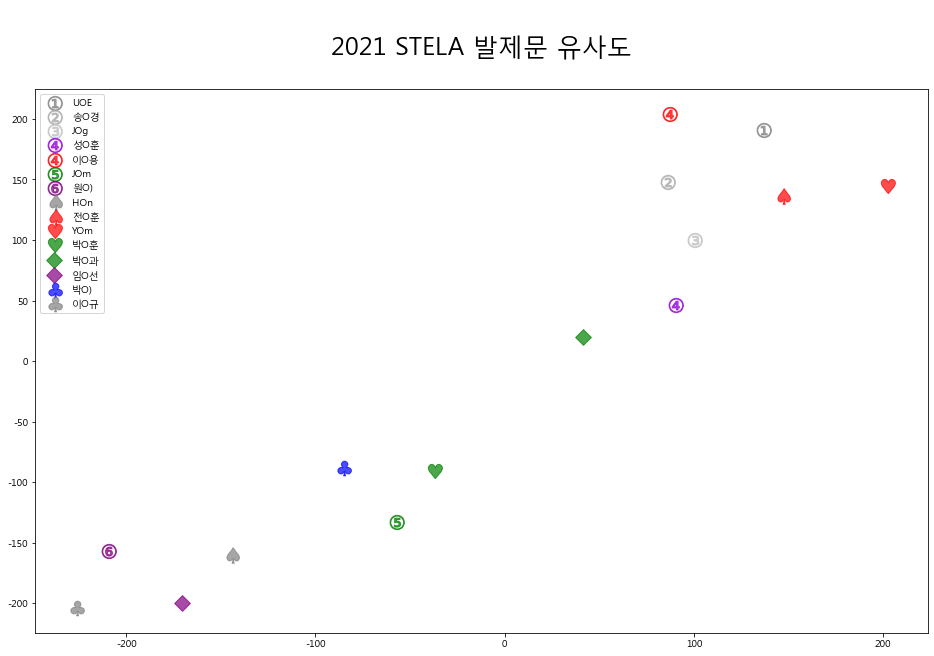

In [24]:
marker_dict = [
    ['$①$', 'gray'],
    ['$②$', 'darkgrey'],
    ['$③$', 'silver'],
    ['$④$', 'darkviolet'],
    ['$④$', 'red'],
    ['$⑤$', 'green'],
    ['$⑥$', 'purple'],

    ['$\spadesuit$', 'gray'],
    ['$\spadesuit$', 'red'],

    ['$\u2665$', 'red'], # -> 속이 찬 하트의 유니코드
    ['$\u2665$', 'green'],

    ['$\u25C6$', 'green'],  # -> 속이 찬 다이아몬드의 유니코드
    ['$\u25C6$', 'purple'],

    ['$\clubsuit$', 'blue'],
    ['$\clubsuit$', 'gray'],
    ['$\clubsuit$', 'silver'],
    ['$\clubsuit$', 'red'],
    ['$\clubsuit$', 'green'],
]

fig = plt.figure(figsize=(16,10))
newLabel = []
for idx, (people, marker) in enumerate(zip(mean_dict.keys(), marker_dict)):
    cleaned_name = people[0] + 'O' + people[-1]
    newLabel.append(cleaned_name)
    
    scatter = plt.scatter(
        xs[idx], ys[idx], # plot x & y
        label = newLabel[idx],
        marker = marker[0],
        c= marker[1], # color
        s= 250, alpha=0.7
    )
    

plt.title('\n2021 STELA 발제문 유사도\n', fontsize=25)
plt.legend(labels= newLabel,
            # loc = 'upper right'
            loc = 'best'
            )
plt.savefig(os.path.join(BASE_DIR, 'RESULT', 'result_tsne.png'))
plt.show()